In [1]:
import numpy as np
import scipy as sc
from numpy.linalg import norm
from scipy.linalg import eig, eigvals
# Visualization libraries as needed, for example:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
def convmat(A, P, Q=None, R=None):
    """
    Construct a convolution matrix from a real-space grid A.
    Supports 1D, 2D, and 3D (assumes A.ndim = 1, 2, or 3).
    """
    # Handle input arguments (1D: P, 2D: P, Q, 3D: P, Q, R)
    if Q is None:
        Q = 1
    if R is None:
        R = 1
    A = np.asarray(A)
    shape = A.shape
    Nx, Ny, Nz = 1, 1, 1
    if A.ndim == 3:
        Nx, Ny, Nz = shape
    elif A.ndim == 2:
        Nx, Ny = shape
    elif A.ndim == 1:
        Nx = shape[0]

    # Indices of spatial harmonics
    p = np.arange(-P//2, P//2+1)
    q = np.arange(-Q//2, Q//2+1)
    r = np.arange(-R//2, R//2+1)
    NH = P*Q*R
    print(f"p = {p}")
    print(f"q = {q}")
    print(f"r = {r}")

    # Fourier coefficients of A (normalized FFT, with fftshift)
    Ahat = np.fft.fftshift(np.fft.fftn(A)) / (Nx * Ny * Nz)
    #print(f"Ahat[:,63,63] = {Ahat[64,:,63]}")
    
    # Zero-order harmonic index
    p0 = Nx//2
    q0 = Ny//2
    r0 = Nz//2
    print(f"p0 = {p0}")
    print(f"q0 = {q0}")
    print(f"r0 = {r0}")

    # Convolution matrix
    C = np.zeros((NH, NH), dtype=np.complex128)
    # For each output block (row/col index)
    rowidx = 0
    for rrow in range(R):
        for qrow in range(Q):
            for prow in range(P):
                row = rrow * Q * P + qrow * P + prow
                for rcol in range(R):
                    for qcol in range(Q):
                        for pcol in range(P):
                            col = rcol * Q * P + qcol * P + pcol
                            pfft = p[prow] - p[pcol]
                            qfft = q[qrow] - q[qcol]
                            rfft = r[rrow] - r[rcol]
                            idx_p = p0 + pfft
                            idx_q = q0 + qfft
                            idx_r = r0 + rfft
                            C[row, col] = Ahat[idx_q, idx_p, idx_r]
    return C

In [3]:
# BCC PARAMETERS
a = 1   # unit cell size in mm
Inf = 0.5  # infill ratio
rs = a * (Inf / np.pi)**0.5

nL = 1.0  # low refractive index
Eps_h = 7.5
nH = np.sqrt(Eps_h)  # high refractive index

# PWEM PARAMETERS
N1 = 128
N2 = N1
N3 = N1

NP = 7
NQ = NP
NR = NP

NSOL = 3

# BAND DIAGRAM PARAMETERS
NBETA = 50
wn_max = 1

In [4]:
# DIRECT LATTICE VECTORS
t1 = a * np.array([1, 0, 0])
t2 = a * np.array([0, 1, 0])
t3 = a * np.array([0, 0, 1])

In [5]:
# RECIPROCAL LATTICE VECTORS
T1 = (2 * np.pi / a) * np.array([1, 0, 0])
T2 = (2 * np.pi / a) * np.array([0, 1, 0])
T3 = (2 * np.pi / a) * np.array([0, 0, 1])

In [6]:
# KEY POINTS OF SYMMETRY
PG = np.array([0, 0, 0])
PX = 0.5 * T2
PM = 0.5 * T1 + 0.5 * T2
PR = 0.5 * T1 + 0.5 * T2 + 0.5 * T3

In [7]:
# PATH AROUND IBZ
KP = np.vstack([PG, PX, PM, PG, PR, PX]).T
KL = ['Γ','X','M','Γ','R','X']

# CALCULATE BETA AXIS RESOLUTION
L = 0
NKP = KP.shape[1]
for nkp in range(NKP-1):
    L += norm(KP[:, nkp+1] - KP[:, nkp])
res = L / NBETA

# BUILD BETA LIST
BETA = KP[:, [0]]
KT = [1]
for nkp in range(NKP-1):
    kp1 = KP[:, nkp]
    kp2 = KP[:, nkp+1]
    L = norm(kp2 - kp1)
    NB = int(np.round(L/res))
    bx = kp1[0] + (kp2[0] - kp1[0]) * np.arange(1, NB+1)/NB
    by = kp1[1] + (kp2[1] - kp1[1]) * np.arange(1, NB+1)/NB
    bz = kp1[2] + (kp2[2] - kp1[2]) * np.arange(1, NB+1)/NB
    BETA = np.hstack((BETA, np.vstack([bx, by, bz])))
    KT.append(BETA.shape[1])
NBETA = BETA.shape[1]

In [8]:
# BUILD UNIT CELL AND CONVOLUTION MATRIX
p = np.linspace(-0.5*a, 0.5*a, N1)
q = np.linspace(-0.5*a, 0.5*a, N2)
r = np.linspace(-0.5*a, 0.5*a, N3)
Q, P, R = np.meshgrid(q, p, r, indexing='ij')  # Note: indexing!

ER = np.zeros((N1, N2, N3))
ER = ((P)**2 + (R)**2 <= rs**2).astype(float)
# ER = 1 - ER # as in your comment for negation if wanted
# CONVERT ER TO REAL MATERIALS
ER = nL**2 + (nH**2 - nL**2) * ER

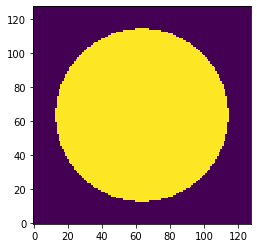

In [9]:
plt.imshow(ER[0,:,:], origin='lower')
plt.show()

In [10]:
ERC = convmat(ER, NP, NQ, NR)  # Ensure your Python version matches MATLAB's
ERC_inv = np.linalg.inv(ERC)

# FOURIER COEFFICIENT MESHGRID
p = np.arange(-NP//2 + 1, NP//2 + 1)
q = np.arange(-NQ//2 + 1, NQ//2 + 1)
r = np.arange(-NR//2 + 1, NR//2 + 1)
R, P, Q = np.meshgrid(q, p, r, indexing='ij')
NH = NP * NQ * NR

# INITIALIZE DATA RECORDS
WN = np.zeros((NSOL, NBETA))

p = [-4 -3 -2 -1  0  1  2  3]
q = [-4 -3 -2 -1  0  1  2  3]
r = [-4 -3 -2 -1  0  1  2  3]
p0 = 64
q0 = 64
r0 = 64


In [11]:
beta_val = np.zeros(NBETA)
for nb in range(NBETA):
    Kx = BETA[0, nb] - P*T1[0] - Q*T2[0] - R*T3[0]
    Ky = BETA[1, nb] - P*T1[1] - Q*T2[1] - R*T3[1]
    Kz = BETA[2, nb] - P*T1[2] - Q*T2[2] - R*T3[2]
    Kflat = np.sqrt(np.abs(Kx)**2 + np.abs(Ky)**2 + np.abs(Kz)**2).transpose(0,2,1).flatten(order='C')
    beta_val[nb] = np.sqrt(BETA[0, nb]**2 + BETA[1, nb]**2 + BETA[2, nb]**2)
    
    # Calculate Perpendicular Polarization Vectors
    p1x = np.eye(NH)
    p1y = np.eye(NH)
    p1z = np.eye(NH)
    p2x = np.eye(NH)
    p2y = np.eye(NH)
    p2z = np.eye(NH)
    for m in range(NH):
        k = np.array([Kx.transpose(0,2,1).flatten(order='C')[m], Ky.transpose(0,2,1).flatten(order='C')[m], Kz.transpose(0,2,1).flatten(order='C')[m]])
        if norm(k) < 1e-10:
            p1 = np.array([1, 0, 0])
            p2 = np.array([0, 1, 0])
        else:
            v = np.array([4*k[1], 2*k[2], 3*k[0]])
            p1 = np.cross(k, v)
            p1 /= norm(p1)
            p2 = np.cross(k, p1)
            p2 /= norm(p2)
        p1x[m, m] = p1[0]
        p1y[m, m] = p1[1]
        p1z[m, m] = p1[2]
        p2x[m, m] = p2[0]
        p2y[m, m] = p2[1]
        p2z[m, m] = p2[2]
        
    # Build Eigen-Value Problem (matrix-matrix operations, ERC must be properly shaped)
    Kmat = np.diag(Kflat)
    #Kmat = sc.sparse.diags(Kflat,0)
    # ERC must act as a matrix; check the shape of ERC!
    # Use matrix multiplication: @ for Python, * for MATLAB
    A11 = (+Kmat @ p2x @ ERC_inv @ Kmat @ p2x
            +Kmat @ p2y @ ERC_inv @ Kmat @ p2y
            +Kmat @ p2z @ ERC_inv @ Kmat @ p2z)
    A12 = (-Kmat @ p2x @ ERC_inv @ Kmat @ p1x
            -Kmat @ p2y @ ERC_inv @ Kmat @ p1y
            -Kmat @ p2z @ ERC_inv @ Kmat @ p1z)
    A21 = (-Kmat @ p1x @ ERC_inv @ Kmat @ p2x
            -Kmat @ p1y @ ERC_inv @ Kmat @ p2y
            -Kmat @ p1z @ ERC_inv @ Kmat @ p2z)
    A22 = (+Kmat @ p1x @ ERC_inv @ Kmat @ p1x
            +Kmat @ p1y @ ERC_inv @ Kmat @ p1y
            +Kmat @ p1z @ ERC_inv @ Kmat @ p1z)
    A = np.block([[A11, A12], [A21, A22]])
    
    # Solve Eigen-Value Problem
    k02 = np.sort(np.linalg.eigvals(A))
    # k02 = np.sort(eigvals(A))
    WN[:, nb] = (a / (2 * np.pi)) * np.real(np.sqrt(k02[:NSOL]))

In [12]:
fn = (1e-9) * (WN / (a * 1e-3)) * (3e8)
fn.shape

(3, 52)

Text(0, 0.5, 'Frequency []')

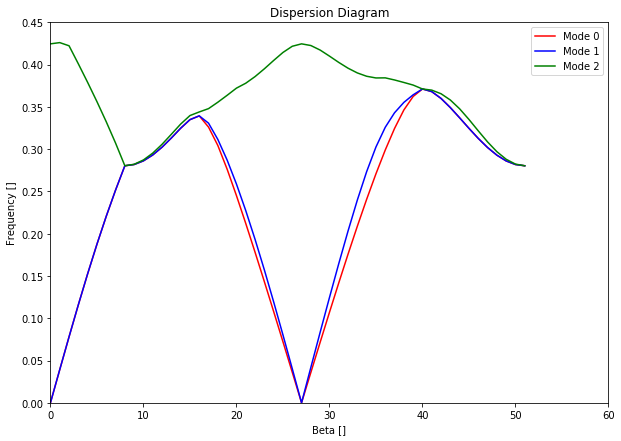

In [13]:
fig = plt.figure(figsize=(10, 7))
plt.plot(WN[0],'r', label=f"Mode 0")
plt.plot(WN[1],'b', label=f"Mode 1")
plt.plot(WN[2],'g', label=f"Mode 2")
#plt.grid()
plt.legend()
plt.ylim([0,0.45])
plt.xlim([0,60])
plt.title('Dispersion Diagram')
plt.xlabel("Beta []")
plt.ylabel("Frequency []")